# Intercomparison

**Author:** Ivan Zvonkov

**Last updated:** Nov 8, 2023

**Description:** Runs intercomparison for Sudan Gedaref, West/South Darfur, Al Jazirah, Central Darfur 2022

## 1. Setup

In [1]:
#earthengine authenticate

In [2]:
import ee
import geemap
import sys
import pandas as pd
import geopandas as gpd
from pathlib import Path

ee.Initialize()

sys.path.append("../..")

from src.compare_covermaps import TARGETS, filter_by_bounds, generate_report, CLASS_COL, COUNTRY_COL
from src.compare_covermaps import TEST_COUNTRIES, TEST_CODE

*** Earth Engine *** Share your feedback by taking our Annual Developer Satisfaction Survey: https://google.qualtrics.com/jfe/form/SV_doiqkQG3NJ1t8IS?source=API


## 2. Read in evaluation set

In [3]:
country = "GedarefDarfurAlJazirah2022"

if country not in TEST_CODE:
    print(f"WARNING: {country} not found in TEST_CODE in src/compare_covermaps.py")
if country not in TEST_COUNTRIES:
    print(f"WARNING: {country} not found in TEST_COUNTRIES in src/compare_covermaps.py")
if country not in TEST_CODE or country not in TEST_COUNTRIES:
    print("Please update src/compare_covermaps.py and restart the notebook.")
else:
    country_code = TEST_CODE[country]
    dataset_path = "../" + TEST_COUNTRIES[country]

In [4]:
if not Path(dataset_path).exists():
    print(f"WARNING: Dataset: {dataset_path} not found, run `dvc pull data/datasets from root.")
else:
    df = pd.read_csv(dataset_path)[["lat", "lon", "class_probability", "subset"]]
    df = df[(df["class_probability"] != 0.5)].copy()
    # use only test data because validation points used for harvest-dev map
    df = df[df["subset"] == "testing"].copy()
    df[CLASS_COL] = (df["class_probability"] > 0.5).astype(int)
    df[COUNTRY_COL] = country

    gdf = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df.lon, df.lat), crs="epsg:4326")
    gdf = filter_by_bounds(country_code=country_code, gdf=gdf)

## 3. Run intercomparison

In [5]:
TARGETS = {k:v for k,v in TARGETS.items()}

In [6]:
skip_cropmaps = "worldcover-v200"
for cropmap in TARGETS.values():
    if country not in cropmap.countries or cropmap.title in skip_cropmaps:
        continue
    print(f"[{country}] sampling " + cropmap.title + "...")
    map_sampled = cropmap.extract_test(gdf).copy()
    gdf = pd.merge(gdf, map_sampled, on=["lat", "lon"], how="left")
    gdf.drop_duplicates(inplace=True)  # TODO find why points get duplicated

[GedarefDarfurAlJazirah2022] sampling copernicus...
[GedarefDarfurAlJazirah2022] sampling worldcover-v100...
[GedarefDarfurAlJazirah2022] sampling worldcereal-v100...
[GedarefDarfurAlJazirah2022] sampling glad...
[GedarefDarfurAlJazirah2022] sampling asap...
[GedarefDarfurAlJazirah2022] sampling dynamicworld...
[GedarefDarfurAlJazirah2022] sampling gfsad-gcep...
[GedarefDarfurAlJazirah2022] sampling gfsad-lgrip...
[GedarefDarfurAlJazirah2022] sampling digital-earth-africa...
[GedarefDarfurAlJazirah2022] sampling esa-cci-africa...
[GedarefDarfurAlJazirah2022] sampling globcover-v23...
[GedarefDarfurAlJazirah2022] sampling globcover-v22...
[GedarefDarfurAlJazirah2022] sampling esri-lulc...
[GedarefDarfurAlJazirah2022] sampling nabil-etal-2021...


In [7]:
comparisons = []
for cropmap in TARGETS.keys():
    if cropmap not in gdf.columns:
        continue
    temp = gdf[[CLASS_COL, cropmap]].dropna()
    comparison = generate_report(cropmap, country, temp[CLASS_COL], temp[cropmap])
    comparisons.append(comparison)

results = pd.concat(comparisons).set_index(["dataset"])

# Add ensemble
ensemble_maps = ["glad", "worldcover-v100", "esri-lulc"] # Should be odd number
print(f"Ensemble maps: {ensemble_maps}")
ensemble = gdf[ensemble_maps].mode(axis='columns')
comparison = generate_report("ensemble-subset", country, gdf[CLASS_COL], ensemble)
comparisons.append(comparison)

results = pd.concat(comparisons).set_index(["dataset"])
results

Ensemble maps: ['glad', 'worldcover-v100', 'esri-lulc']


,country,crop_f1,std_crop_f1,accuracy,std_acc,crop_recall_pa,std_crop_pa,noncrop_recall_pa,std_noncrop_pa,crop_precision_ua,std_crop_ua,noncrop_precision_ua,std_noncrop_ua,crop_support,noncrop_support,tn,fp,fn,tp
dataset,,,,,,,,,,,,,,,,,,,
copernicus,GedarefDarfurAlJazirah2022,0.28,0.32,0.85,0.03,0.20,0.07,0.96,0.01,0.44,0.18,0.88,0.03,20,120,115,5,16,4
worldcover-v100,GedarefDarfurAlJazirah2022,0.14,0.27,0.83,0.03,0.10,0.06,0.95,0.01,0.25,0.16,0.86,0.03,20,120,114,6,18,2
worldcereal-v100,GedarefDarfurAlJazirah2022,0.47,0.32,0.86,0.03,0.45,0.09,0.92,0.02,0.50,0.12,0.91,0.03,20,120,111,9,11,9
glad,GedarefDarfurAlJazirah2022,0.39,0.32,0.84,0.03,0.35,0.09,0.92,0.02,0.44,0.13,0.90,0.03,20,120,111,9,13,7
asap,GedarefDarfurAlJazirah2022,0.37,0.28,0.78,0.03,0.45,0.10,0.83,0.02,0.31,0.09,0.90,0.03,20,120,100,20,11,9
dynamicworld,GedarefDarfurAlJazirah2022,0.50,0.30,0.84,0.03,0.55,0.10,0.89,0.02,0.46,0.10,0.92,0.02,20,120,107,13,9,11
gfsad-gcep,GedarefDarfurAlJazirah2022,0.35,0.32,0.84,0.03,0.30,0.09,0.93,0.02,0.43,0.14,0.89,0.03,20,120,112,8,14,6
gfsad-lgrip,GedarefDarfurAlJazirah2022,0.30,0.32,0.84,0.03,0.25,0.08,0.93,0.01,0.38,0.14,0.88,0.03,20,120,112,8,15,5
digital-earth-africa,GedarefDarfurAlJazirah2022,0.44,0.32,0.86,0.03,0.40,0.09,0.93,0.02,0.50,0.13,0.90,0.03,20,120,112,8,12,8


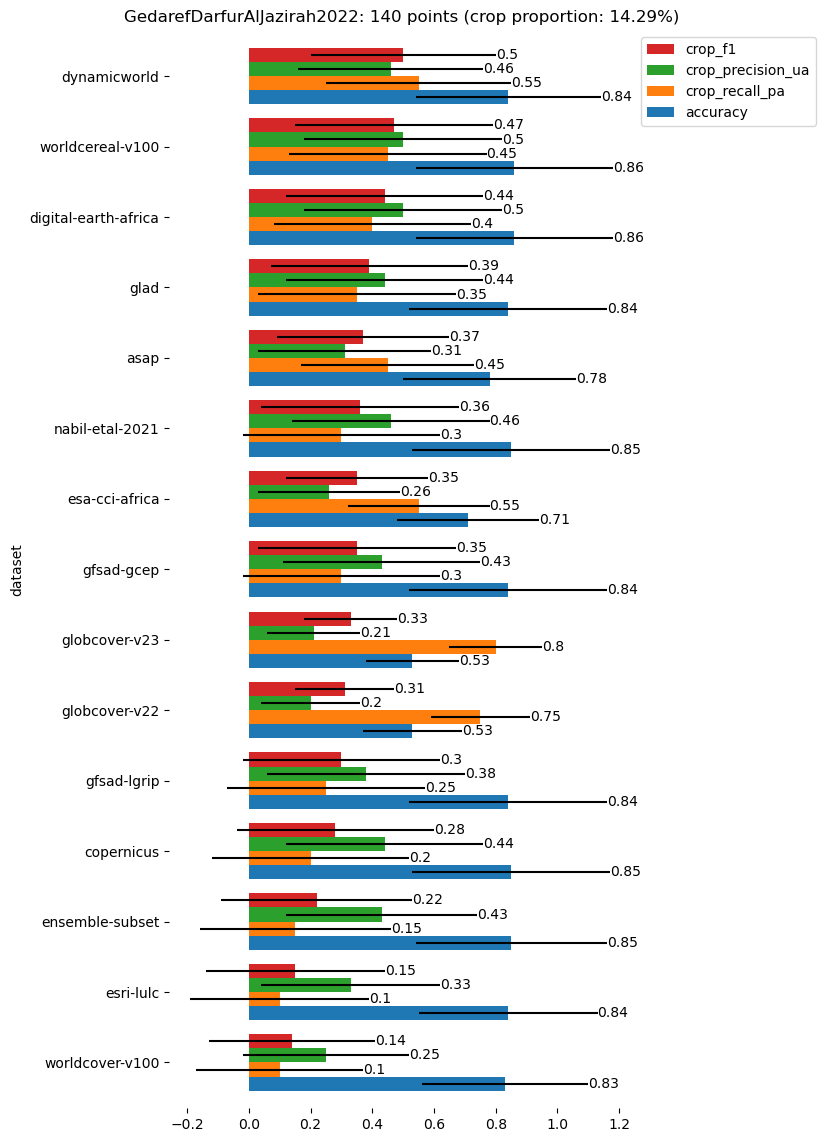

In [8]:
crop_proportion = round(gdf[CLASS_COL].value_counts(normalize=True)[1], 4) * 100
ax = results.sort_values("crop_f1").plot(
    y=["accuracy", "crop_recall_pa", "crop_precision_ua", "crop_f1"], 
    xerr="std_crop_f1",
    kind="barh", 
    figsize=(6, 14),
    width=0.8,
    title=f"{country}: {len(gdf)} points (crop proportion: {crop_proportion}%)",
);

for c in ax.containers[1::2]:
    ax.bar_label(c)

for border in ["top", "right", "bottom", "left"]:
    ax.spines[border].set_visible(False)

ax.legend(bbox_to_anchor=(1, 1), reverse=True);

## 4. Visualize best available map

In [10]:
# Run this cell to view and export map
print("To view and export map copy and paste the text below the dashed line into GEE\n" + "-"*100)
best_dataset = results["crop_f1"].idxmax()

print("var palettes = require('users/gena/packages:palettes');")
print("var classVis = {palette: palettes.cmocean.Speed[7].slice(0,-2)}")
print('''var aoi = ee.FeatureCollection("FAO/GAUL/2015/level1")
    .filter(ee.Filter.inList('ADM1_NAME', ['Gadaref', 'Western Darfur', 'Southern Darfur','Al Jazeera']));''')

print("Map.centerObject(aoi, 7);")
if best_dataset in TARGETS:
    print(TARGETS[best_dataset].ee_script(country, include_prefix=False))
else:
    image_var_names = [TARGETS[d].title_safe for d in ensemble_maps]
    for i, dataset in enumerate(ensemble_maps):
        print(TARGETS[dataset].ee_script(country, include_prefix=(i == 0), include_export=False))
        print("\n")
    print(f"var ensemble = ee.ImageCollection.fromImages([{', '.join(image_var_names)}]).mode()")
    print(f"Map.addLayer(ensemble, classVis, 'Cropland from ensemble');")
    print(f"""
Export.image.toCloudStorage({{
    image: ensemble,
    description: "{country}_ensemble_{'_'.join(image_var_names)}",
    bucket: 'crop-mask-preds-merged',
    fileNamePrefix: "{country}_ensemble_{'_'.join(image_var_names)}",
    region: aoi,
    scale: 10,
    crs: "EPSG:4326",
    maxPixels: 1e10,
    skipEmptyTiles: true
}});""")

To view and export map copy and paste the text below the dashed line into GEE
----------------------------------------------------------------------------------------------------
var palettes = require('users/gena/packages:palettes');
var classVis = {palette: palettes.cmocean.Speed[7].slice(0,-2)}
var aoi = ee.FeatureCollection("FAO/GAUL/2015/level1")
    .filter(ee.Filter.inList('ADM1_NAME', ['Gadaref', 'Western Darfur', 'Southern Darfur','Al Jazeera']));
Map.centerObject(aoi, 7);
var dynamicworld = ee.ImageCollection(
            ee.ImageCollection("GOOGLE/DYNAMICWORLD/V1")
            .filter(ee.Filter.date("2019-01-01", "2020-01-01"))
            .select(["label"])
            .mode()
        ).filterBounds(aoi).mosaic().clip(aoi);
dynamicworld = dynamicworld.eq(4).rename('crop')
Map.addLayer(dynamicworld, classVis, 'Cropland from dynamicworld');
Export.image.toCloudStorage({
    image: dynamicworld,
    description: "GedarefDarfurAlJazirah2022_dynamicworld",
    bucket: 'crop-mask